In [1]:
import os

# Path to the dataset (as per the Kaggle dataset structure)
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# List all subfolders
for split in os.listdir(dataset_path):
    split_path = os.path.join(dataset_path, split)
    print(f"\n{split.upper()} folder contents:")
    print(os.listdir(split_path))


CHEST_XRAY folder contents:
['val', '.DS_Store', 'test', 'train']

__MACOSX folder contents:
['chest_xray', '._chest_xray']

VAL folder contents:
['PNEUMONIA', 'NORMAL']

TEST folder contents:
['PNEUMONIA', 'NORMAL']

TRAIN folder contents:
['PNEUMONIA', 'NORMAL']


In [2]:
# Import all libraries 
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
print("All libraries impotred successfully ! ") 

2025-08-07 08:17:58.527647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754554678.706303      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754554678.762545      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries impotred successfully ! 


In [3]:
# Count the number of images in each class 
for split in ['train','val','test'] : 
    split_path = os.path.join(dataset_path,split) 
    print(f"\n{split.upper()} set : ") 
    for class_name in os.listdir(split_path) :
        class_path = os.path.join(split_path,class_name) 
        num_images = len(os.listdir(class_path)) 
        print(f"{class_name} : {num_images} images") 


TRAIN set : 
PNEUMONIA : 3875 images
NORMAL : 1341 images

VAL set : 
PNEUMONIA : 8 images
NORMAL : 8 images

TEST set : 
PNEUMONIA : 390 images
NORMAL : 234 images


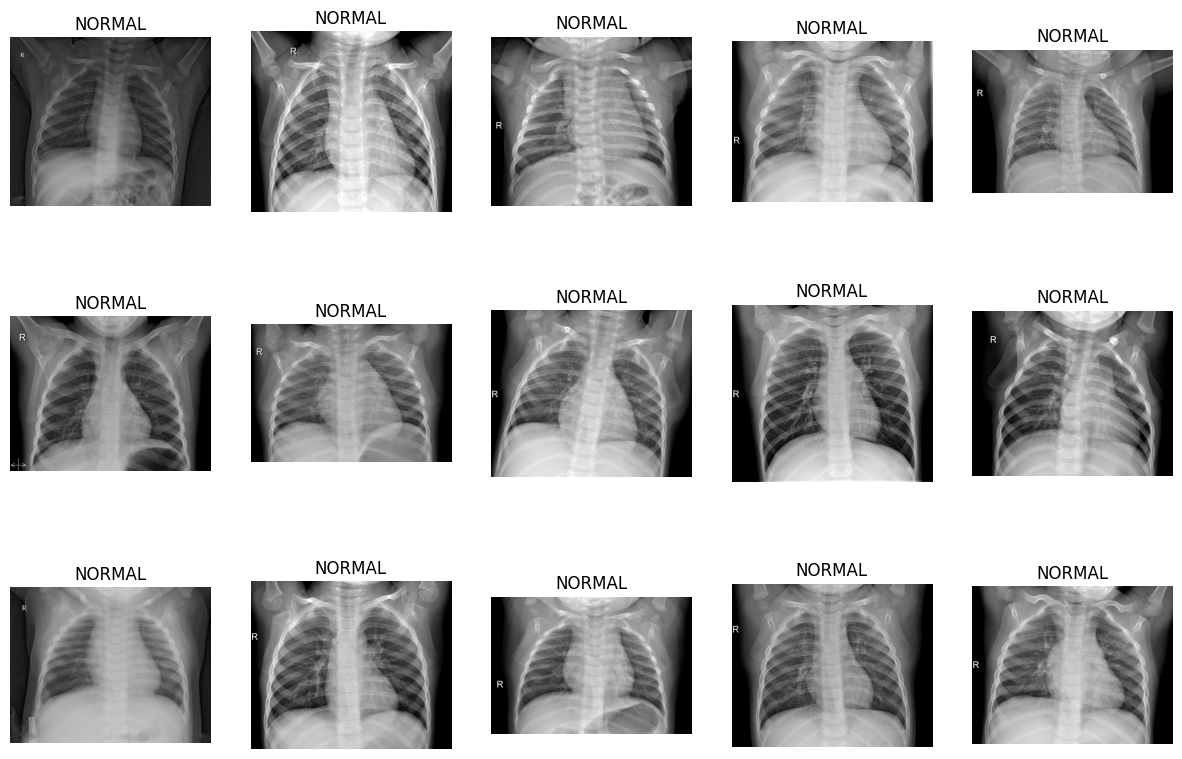

In [4]:
# Visualize sample images for normal chest x ray 
def show_images(split = 'train',class_name = 'PNEUMONIA',num_images = 15) : 
    folder_path = os.path.join(dataset_path,split,class_name) 
    images = os.listdir(folder_path)[:num_images] 

    rows = 3
    cols = 5
    plt.figure(figsize = (15,10))  
    for i,img_name in enumerate(images) : 
        img_path = os.path.join(folder_path,img_name) 
        img = mpimg.imread(img_path) 
        plt.subplot(rows,cols,i+1)  
        plt.imshow(img,cmap = 'gray') 
        plt.title(f'{class_name}') 
        plt.axis('off') 
    plt.show()

show_images(split='train', class_name='NORMAL')


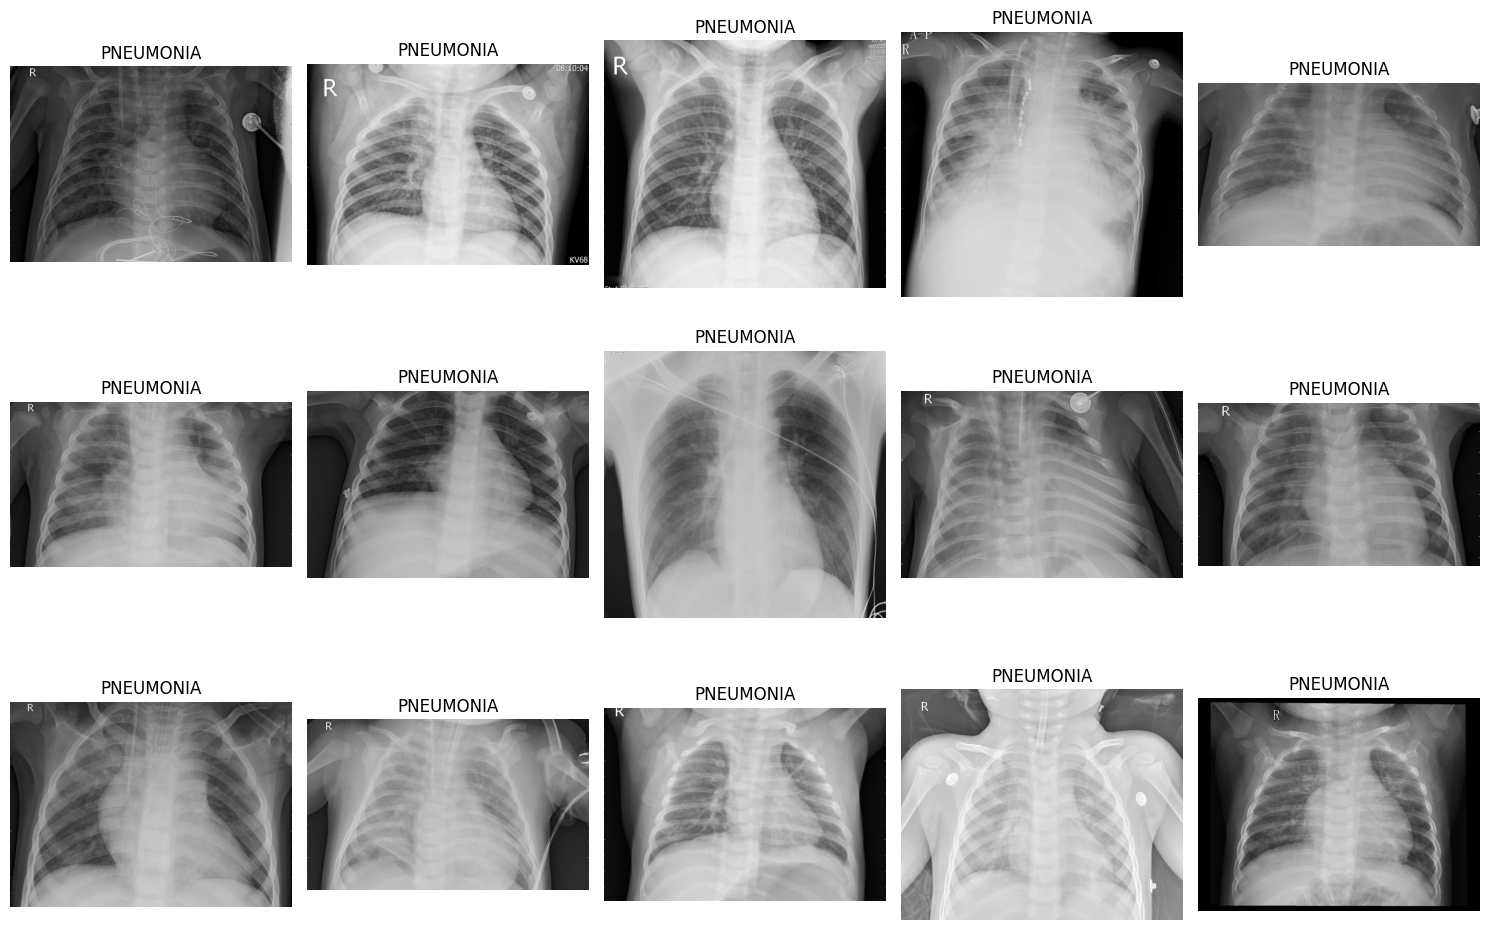

In [5]:
# Visualize sample images for infected chest x ray 
def show_images(split = 'train',class_name = 'PNEUMONIA',num_images = 15) : 
    folder_path = os.path.join(dataset_path,split,class_name) 
    images = os.listdir(folder_path)[:num_images] 

    rows = 3
    cols = 5
    plt.figure(figsize = (15,10))  
    for i,img_name in enumerate(images) : 
        img_path = os.path.join(folder_path,img_name) 
        img = mpimg.imread(img_path) 
        plt.subplot(rows,cols,i+1)  
        plt.imshow(img,cmap = 'gray') 
        plt.title(f'{class_name}') 
        plt.axis('off') 
    plt.tight_layout() 
    plt.show()

show_images()


In [6]:


# Set image size and batch size
img_size = (150, 150)
batch_size = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation/test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Load validation data
val_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("Data generators made ! ") 

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data generators made ! 


In [8]:
# Load Densenet CNN Model 
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense 
from tensorflow.keras.models import Model 

# Load model without top layer 
base_model = DenseNet121(weights = 'imagenet',include_top = False , input_shape = (150,150,3)) 

# Freeze the base model 
base_model.trainable = False 

# Add customs layers on top 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation = 'relu')(x) 
output = Dense(1,activation = 'sigmoid')(x) 

# Build the full model 
model = Model(inputs = base_model.input,outputs = output) 
print("Model Loaded Successfully! ") 

Model Loaded Successfully! 


In [11]:
# Compile the model 
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'] 
) 
print('Model compiled Successfully ! ') 

Model compiled Successfully ! 


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)
print('Model trained Successfully') 


Epoch 1/15


I0000 00:00:1754556365.486488     122 service.cc:148] XLA service 0x7e8c480068a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754556365.487179     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754556368.379936     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:25:19 32s/step - accuracy: 0.8750 - loss: 0.4195

I0000 00:00:1754556377.994135     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 753ms/step - accuracy: 0.8308 - loss: 0.3984 - val_accuracy: 0.7500 - val_loss: 0.5519
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9228 - loss: 0.2001 - val_accuracy: 0.8750 - val_loss: 0.4643
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - accuracy: 0.9259 - loss: 0.1846 - val_accuracy: 0.8750 - val_loss: 0.4924
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9430 - loss: 0.1585 - val_accuracy: 0.8750 - val_loss: 0.4438
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9359 - loss: 0.1650 - val_accuracy: 0.8750 - val_loss: 0.3608
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9342 - loss: 0.1658 - val_accuracy: 0.8750 - val_loss: 0.3878
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9518 - loss: 0.1369 - val_accuracy: 0.8750 - val_loss: 0.4086
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9423 - loss: 0.1411 - va

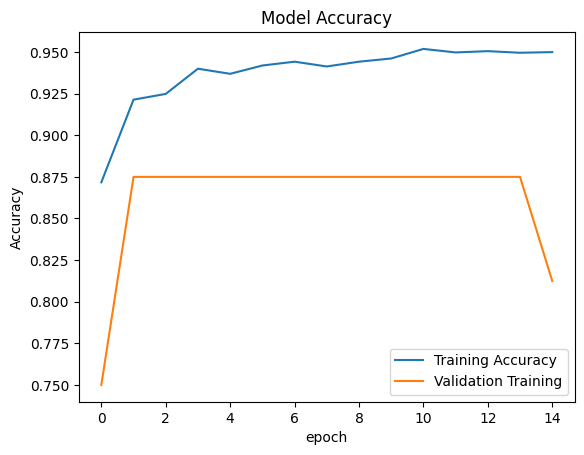

In [13]:
# Plot Training and loss accuracy 
plt.plot(history.history['accuracy'],label = 'Training Accuracy') 
plt.plot(history.history['val_accuracy'],label = 'Validation Training') 
plt.title('Model Accuracy') 
plt.xlabel('epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show() 



In [16]:
# Funciton for Testing predection on images 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    """
    Predicts whether the input chest X-ray image shows PNEUMONIA or NORMAL.
    
    Args:
        img_path (str): Path to the image.
        model (tf.keras.Model): Trained DenseNet model.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]

    # Model prediction
    prediction = model.predict(img_array)[0][0]

    # Interpret prediction
    predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Display the image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Also return result if needed for further use
    return predicted_class, confidence
print('Function created Successfully') 


Function created Successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


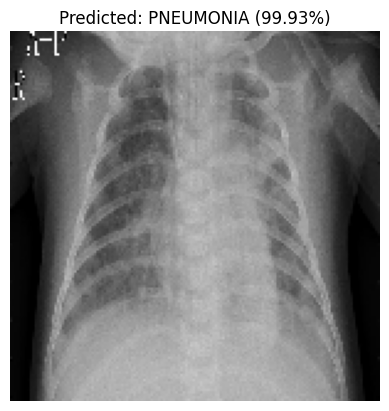

('PNEUMONIA', 0.99926096)

In [22]:
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg' 
predict_image(test_path,model) 

In [21]:
# Load and save the model 

model.save("pneumonia_detector_model.h5")
print('Model Saved ! ') 


Model Saved ! 
